In [1]:
import os
os.chdir("../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [5]:
sc.settings.set_figure_params(dpi=200)

In [6]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Tabula_muris", "Zeisel"]

# Loading mouse brain datasets and data preparation

In [7]:
adata = sc.read("./data/mouse_brain/mouse_brain_normalized_hvg_subsampled.h5ad")
adata

AnnData object with n_obs × n_vars = 568517 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

## Number of cells in each batch

In [8]:
adata.obs[condition_key].value_counts()

Saunders        347636
Zeisel          145954
Rosenberg        67071
Tabula_muris      7856
Name: study, dtype: int64

In [9]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 414707 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 153810 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

## Train/Test Split

In [11]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.80)

In [12]:
train_adata.shape, valid_adata.shape

((331765, 2000), (82942, 2000))

In [13]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())
n_conditions

2

# Create & Train model with training data

In [14]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[512, 128, 64, 20],
                             use_batchnorm=False,
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.00005,
                             beta=1000,
                             eta=0.1,
                             clip_value=1e6,
                             loss_fn='mse',
                             model_path="./models/CVAE/subsample/mouse_brain/before/",
                             dropout_rate=0.05,
                             output_activation='relu')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## We assign each study to a numerical label 

In [15]:
train_adata.obs[condition_key].value_counts()

Saunders     278011
Rosenberg     53754
Name: study, dtype: int64

In [16]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(sorted(conditions), target_conditions)
condition_encoder

{'Rosenberg': 0, 'Saunders': 1}

## Training the network

In [17]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=1000,
              batch_size=1024, 
              early_stop_limit=10,
              lr_reducer=8, 
              n_per_epoch=0,
              save=True,
              retrain=True,
              verbose=5)

Instructions for updating:
Use tf.cast instead.
 |██------------------| 10.3%  - loss: 169.2176 - reconstruction_loss: 163.2746 - mmd_loss: 5.9431 - val_loss: 166.8436 - val_reconstruction_loss: 160.8171 - val_mmd_loss: 6.0265

In [18]:
network.condition_encoder

{'Rosenberg': 0, 'Saunders': 1}

In [19]:
subsampled_adata = sc.pp.subsample(adata_for_training, n_obs=50000, copy=True)

In [20]:
encoder_labels, _ = surgeon.utils.label_encoder(
    subsampled_adata, label_encoder=network.condition_encoder, condition_key=condition_key)

In [21]:
latent_adata = network.to_mmd_layer(subsampled_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 50000 × 20 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

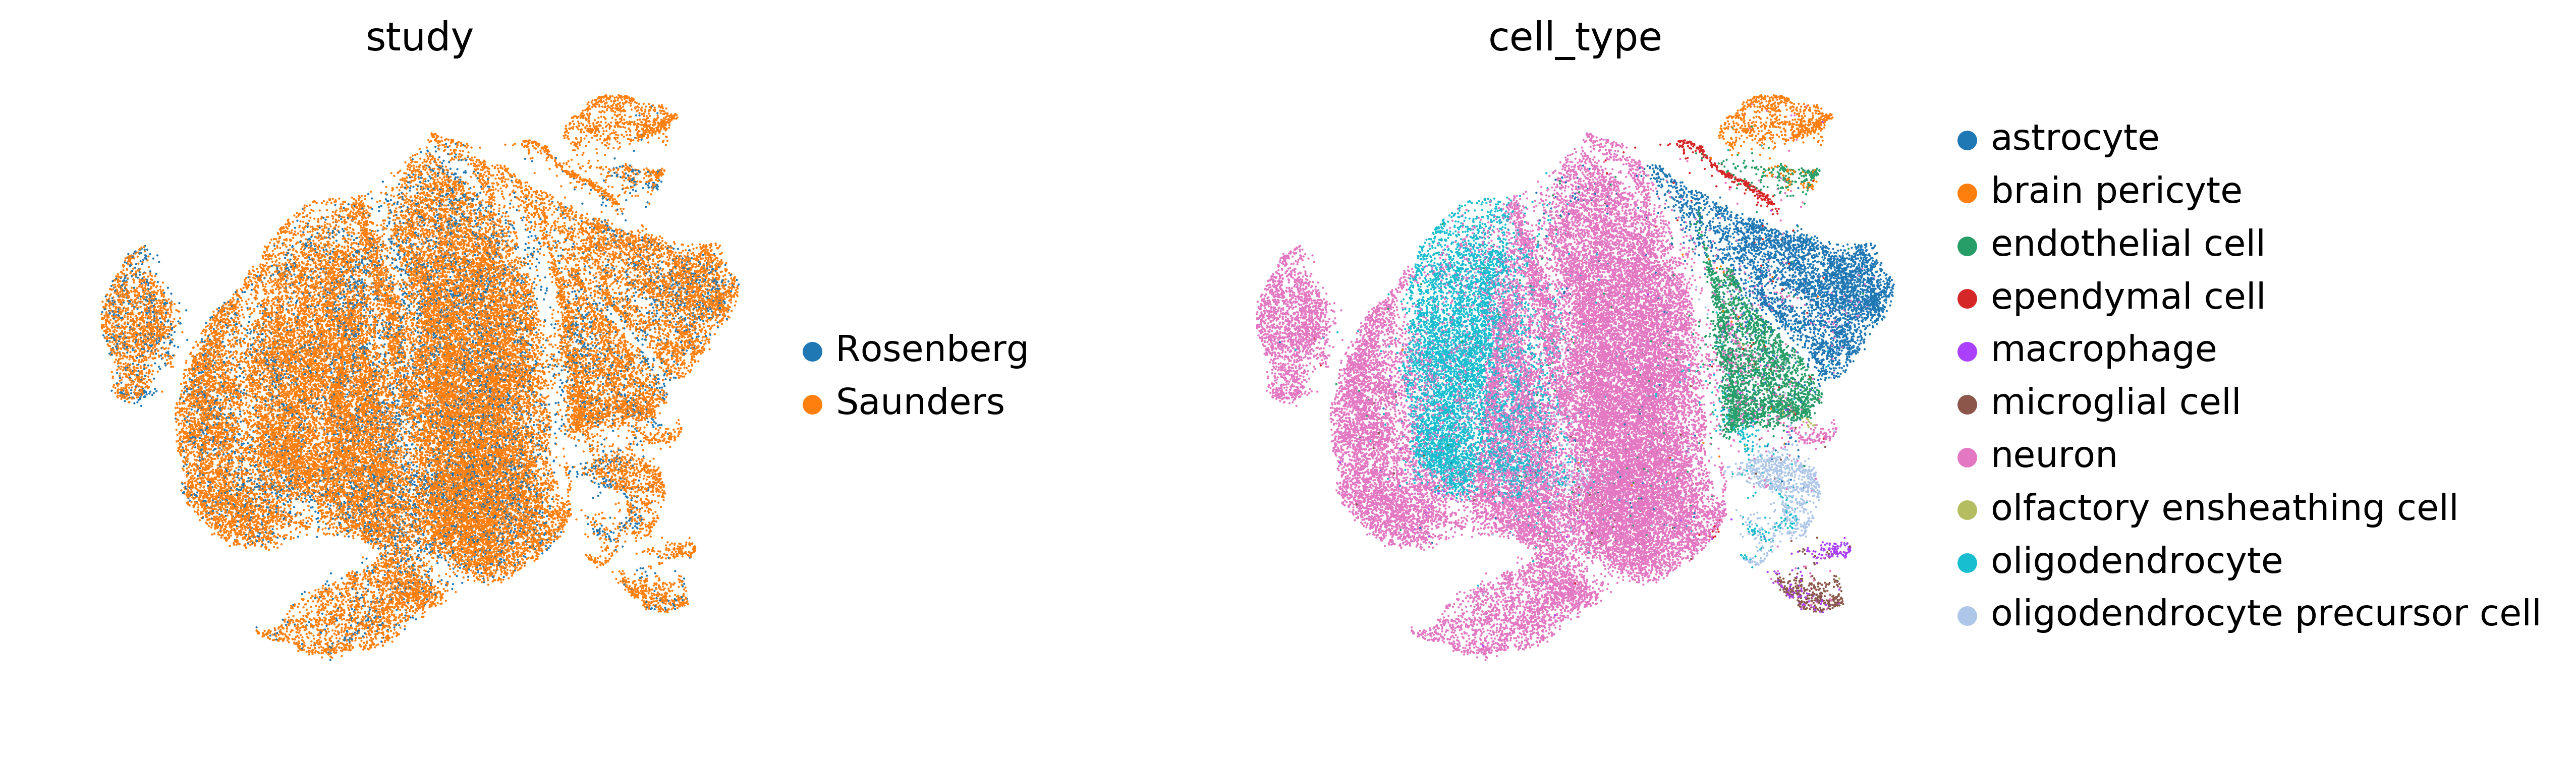

In [23]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

In [24]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              init='Xavier', 
                              freeze=True,
                              freeze_expression_input=True,
                              remove_dropout=True,
                              new_training_kwargs={"beta": 1000, "eta": 0.1},
                              print_summary=False,
                             )

In [25]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [26]:
new_network.model_path = "./models/CVAE/tabula_senis_mca/after/"

In [27]:
new_network.condition_encoder

{'Rosenberg': 0, 'Saunders': 1, 'Tabula_muris': 2, 'Zeisel': 3}

In [ ]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=1000,
                  batch_size=1024, 
                  early_stop_limit=20,
                  lr_reducer=15, 
                  n_per_epoch=0,
                  save=False,
                  retrain=True,
                  verbose=5)

 |█████---------------| 26.4%  - loss: 275.1870 - reconstruction_loss: 249.4672 - mmd_loss: 25.7198 - val_loss: 274.5547 - val_reconstruction_loss: 249.4089 - val_mmd_loss: 25.1458

In [29]:
new_network.condition_encoder

{'Rosenberg': 0, 'Saunders': 1, 'Tabula_muris': 2, 'Zeisel': 3}

In [30]:
subsampled_adata = sc.pp.subsample(adata_out_of_sample, n_obs=50000, copy=True)

In [31]:
encoder_labels, _ = surgeon.utils.label_encoder(
    subsampled_adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)

In [32]:
latent_adata = new_network.to_mmd_layer(subsampled_adata, encoder_labels, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 50000 × 20 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'

In [33]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

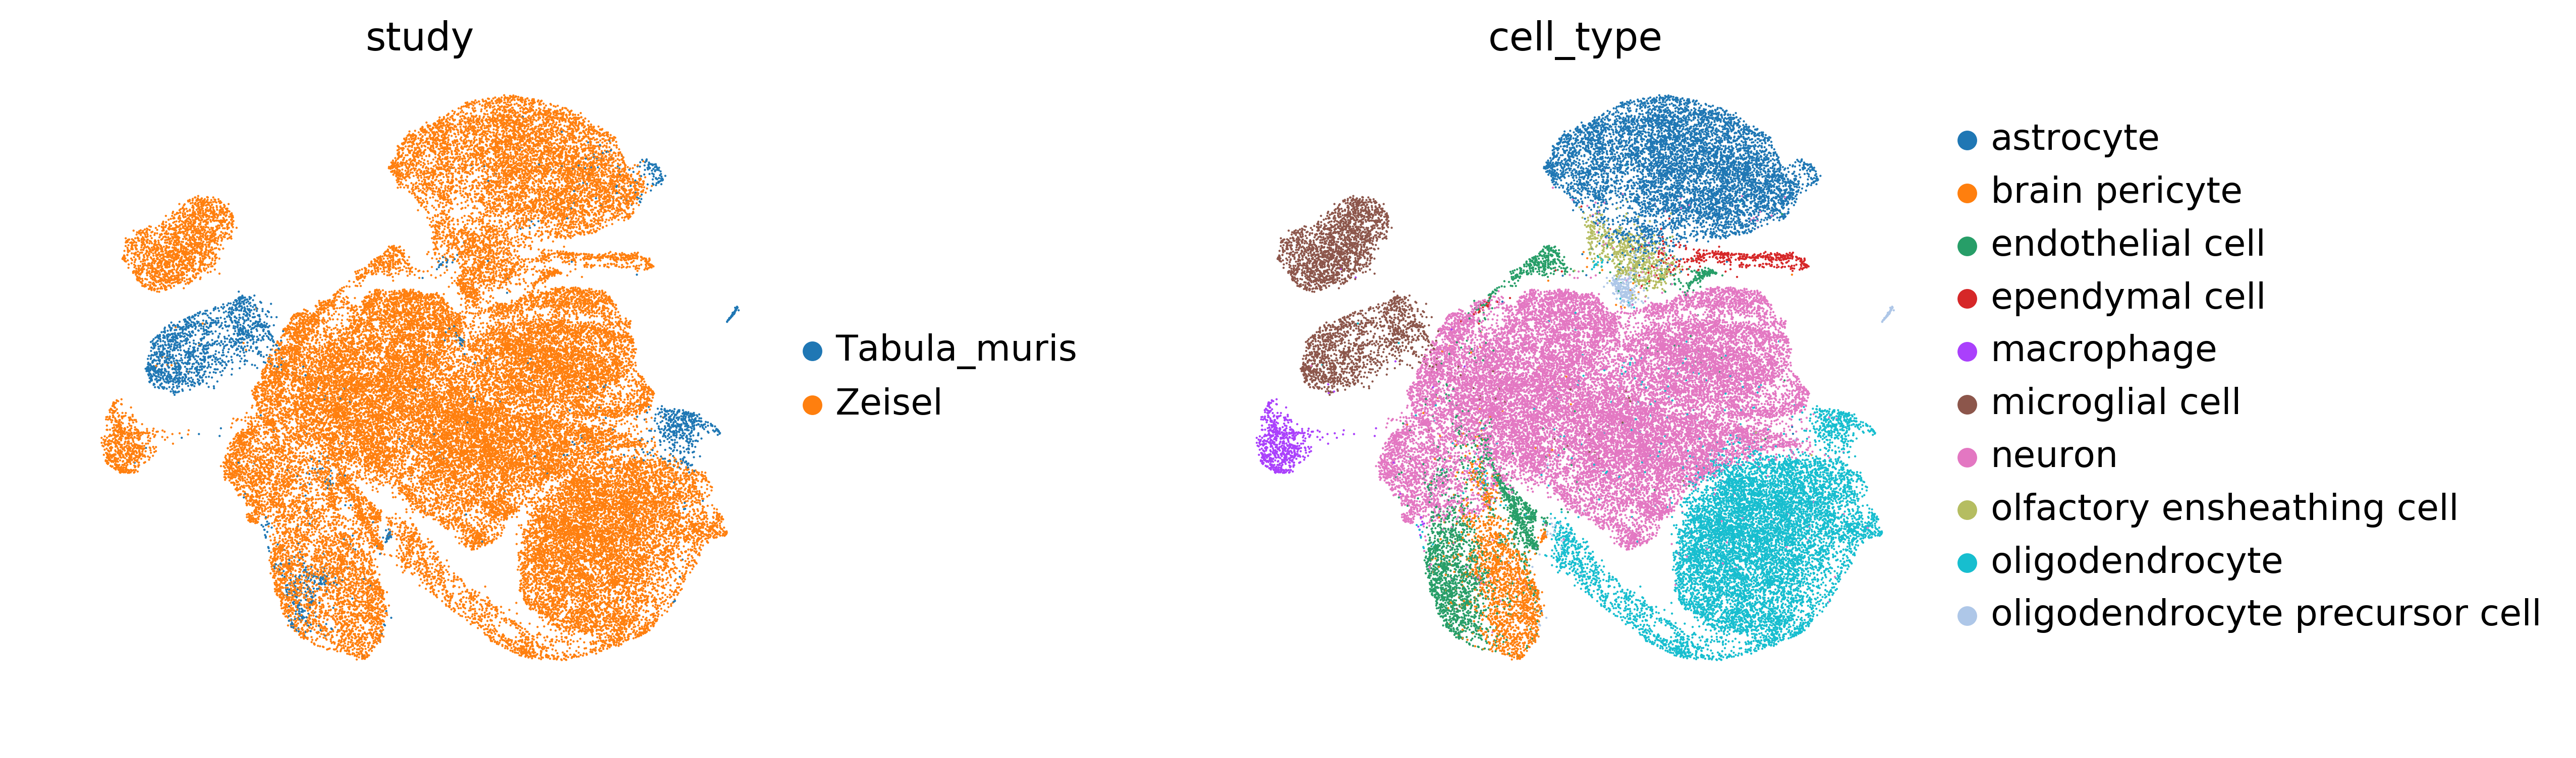

In [34]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           wspace=0.5, frameon=False)

In [35]:
surgeon.metrics.entropy_batch_mixing(latent_adata, label_key=condition_key, n_neighbors=15)

0.012326466245621427

In [36]:
surgeon.metrics.knn_purity(latent_adata, label_key=condition_key, n_neighbors=15)

0.9336496870824034